In [5]:
import os
import json
import random
from pathlib import Path
from typing import List, Dict

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF

import wandb
wandb.login(key="4eb296e6347de044e383e5b50234733dafbc19db")
wandb.init(project="dual-unet-polygons")

IMG_SIZE = 128               
BATCH_SIZE = 16
LR = 1e-3
NUM_EPOCHS = 30
NUM_WORKERS = 4
SAVE_DIR = "checkpoints"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_WANDB = True 
SEED = 42
COLOR_LOSS_WEIGHT = 2.0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

class PolygonColorDataset(Dataset):
    def __init__(self, root: str, color2idx: Dict[str,int]=None, transform=None, augment=False):
        self.root = Path(root)
        with open(self.root / "data.json", "r") as f:
            data = json.load(f)
        if isinstance(data, dict):
            data_items = list(data.values())
        else:
            data_items = data

        self.items = data_items
        self.inputs_dir = self.root / "inputs"
        self.outputs_dir = self.root / "outputs"
        self.augment = augment

        if color2idx is None:
            colors = sorted({it["colour"].lower() for it in self.items})
            self.color2idx = {c:i for i, c in enumerate(colors)}
        else:
            self.color2idx = color2idx

        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
            ])

    def __len__(self):
        return len(self.items)

    def _load_image(self, path):
        img = Image.open(path).convert("RGB")
        return img

    def __getitem__(self, idx):
        it = self.items[idx]
        inp_name = it["input_polygon"]
        out_name = it["output_image"]
        color_name = it["colour"].lower()

        inp_path = self.inputs_dir / inp_name
        out_path = self.outputs_dir / out_name

        inp_img = Image.open(inp_path).convert("L")   
        out_img = Image.open(out_path).convert("RGB") 

        inp_img = inp_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        out_img = out_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

        if self.augment:
            angle = random.uniform(-30, 30)
            inp_img = TF.rotate(inp_img, angle, fill=0)
            out_img = TF.rotate(out_img, angle, fill=(255,255,255))
            if random.random() < 0.5:
                inp_img = TF.hflip(inp_img)
                out_img = TF.hflip(out_img)

        inp_t = TF.to_tensor(inp_img)           
        out_t = TF.to_tensor(out_img)          

        color_idx = self.color2idx[color_name]

        return {
            "input": inp_t,
            "color_idx": torch.tensor(color_idx, dtype=torch.long),
            "target": out_t
        }

    @staticmethod
    def build_vocab_from_json(json_path: str):
        with open(json_path, "r") as f:
            data = json.load(f)
        if isinstance(data, dict):
            items = list(data.values())
        else:
            items = data
        colors = sorted({it["colour"].lower() for it in items})
        return {c:i for i,c in enumerate(colors)}


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, color_emb_dim=128):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

        self.film_gamma = nn.Linear(color_emb_dim, out_ch)
        self.film_beta = nn.Linear(color_emb_dim, out_ch)

    def forward(self, x1, x2, color_emb=None):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)  
        x = self.conv(x)               

        if color_emb is not None:
            gamma = self.film_gamma(color_emb)   
            beta = self.film_beta(color_emb)   
            gamma = gamma.unsqueeze(-1).unsqueeze(-1)
            beta = beta.unsqueeze(-1).unsqueeze(-1)
            x = gamma * x + beta
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch=3):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class ColorEncoder(nn.Module):
    def __init__(self, n_colors, embed_dim=128, out_channels=256, spatial_size=IMG_SIZE // (2**4)):
        super().__init__()
        self.embedding = nn.Embedding(n_colors, embed_dim)
        self.fc_map = nn.Sequential(
            nn.Linear(embed_dim, out_channels * spatial_size * spatial_size),
            nn.ReLU(inplace=True)
        )
        self.embed_dim = embed_dim
        self.out_channels = out_channels
        self.spatial_size = spatial_size

    def forward(self, color_idx):
        emb = self.embedding(color_idx)           
        x = self.fc_map(emb)                       
        B = x.shape[0]
        x = x.view(B, self.out_channels, self.spatial_size, self.spatial_size)
        return x, emb


class DualEncoderUNet(nn.Module):
    def __init__(self, n_colors, in_channels=1, out_channels=3, base_filters=64, color_emb_dim=128):
        super().__init__()
        f = base_filters
        self.inc = DoubleConv(in_channels, f)      
        self.down1 = Down(f, f*2)                   
        self.down2 = Down(f*2, f*4)                 
        self.down3 = Down(f*4, f*8)                 
        self.down4 = Down(f*8, f*8)                

        self.color_encoder = ColorEncoder(n_colors, embed_dim=color_emb_dim,
                                          out_channels=256, spatial_size=IMG_SIZE // (2**4))

        self.bottleneck_conv = DoubleConv(512 + 256, 512)

        self.up1 = Up(512 + 512, 256, color_emb_dim=color_emb_dim) 
        self.up2 = Up(256 + 256, 128, color_emb_dim=color_emb_dim)
        self.up3 = Up(128 + 128, 64, color_emb_dim=color_emb_dim)
        self.up4 = Up(64 + 64, 64, color_emb_dim=color_emb_dim)
        self.outc = OutConv(64, out_channels)

    def forward(self, polygon_img, color_idx):
        x1 = self.inc(polygon_img)   
        x2 = self.down1(x1)          
        x3 = self.down2(x2)           
        x4 = self.down3(x3)          
        x5 = self.down4(x4)          

        c_map, c_emb = self.color_encoder(color_idx)   
        if c_map.shape[2:] != x5.shape[2:]:
            c_map = F.interpolate(c_map, size=x5.shape[2:], mode='bilinear', align_corners=False)

        bottleneck = torch.cat([x5, c_map], dim=1)    
        bottleneck = self.bottleneck_conv(bottleneck) 

        x = self.up1(bottleneck, x4, color_emb=c_emb)
        x = self.up2(x, x3, color_emb=c_emb)
        x = self.up3(x, x2, color_emb=c_emb)
        x = self.up4(x, x1, color_emb=c_emb)

        out = self.outc(x)
        out = torch.sigmoid(out)
        return out



def compute_mean_color_inside_mask(image, mask):
    B = image.shape[0]
    mask_flat = mask.view(B, 1, -1)          
    img_flat = image.view(B, 3, -1)          
    masked_sum = (img_flat * mask_flat).sum(dim=2)  
    denom = mask_flat.sum(dim=2).clamp(min=1e-6)     
    mean_rgb = masked_sum / denom                   
    return mean_rgb

def train_one_epoch(model, loader, optimizer, loss_fn, device, epoch, log_freq=50):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(loader):
        inp = batch["input"].to(device)          
        color_idx = batch["color_idx"].to(device)
        target = batch["target"].to(device)      

        optimizer.zero_grad()
        pred = model(inp, color_idx)             

        recon_loss = loss_fn(pred, target)

        mask = (inp > 0.5).float()   
        pred_mean = compute_mean_color_inside_mask(pred, mask)   
        target_mean = compute_mean_color_inside_mask(target, mask) 
        color_loss = F.mse_loss(pred_mean, target_mean)

        loss = recon_loss + COLOR_LOSS_WEIGHT * color_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % log_freq == 0:
            avg = running_loss / log_freq
            print(f"Epoch {epoch} Iter {i+1}/{len(loader)} - loss: {avg:.6f} (recon={recon_loss.item():.6f}, color={color_loss.item():.6f})")
            if USE_WANDB:
                wandb.log({"train/loss": avg, "train/recon": recon_loss.item(), "train/color": color_loss.item(), "epoch": epoch})
            running_loss = 0.0


def validate(model, loader, loss_fn, device, epoch):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for batch in loader:
            inp = batch["input"].to(device)
            color_idx = batch["color_idx"].to(device)
            target = batch["target"].to(device)
            pred = model(inp, color_idx)
            loss = loss_fn(pred, target)
            total += loss.item() * inp.size(0)
    avg = total / len(loader.dataset)
    print(f"Val Epoch {epoch} - loss: {avg:.6f}")
    if USE_WANDB:
        wandb.log({"val/loss": avg, "epoch": epoch})
    return avg

def main():
    dataset_root = "dataset/training"
    val_root = "dataset/validation"

    color2idx = PolygonColorDataset.build_vocab_from_json(os.path.join(dataset_root, "data.json"))
    n_colors = len(color2idx)
    print("Colors:", color2idx)

    train_ds = PolygonColorDataset(dataset_root, color2idx=color2idx, augment=True)
    val_ds = PolygonColorDataset(val_root, color2idx=color2idx, augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    model = DualEncoderUNet(n_colors=n_colors, in_channels=1, out_channels=3, base_filters=64)
    model = model.to(DEVICE)

    criterion = nn.L1Loss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

    if USE_WANDB:
        wandb.init(project="dual-unet-polygons")
        wandb.watch(model)

    os.makedirs(SAVE_DIR, exist_ok=True)
    best_val = float("inf")
    for epoch in range(1, NUM_EPOCHS+1):
        train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch)
        val_loss = validate(model, val_loader, criterion, DEVICE, epoch)
        scheduler.step(val_loss)

        # save checkpoint
        ckpt_path = os.path.join(SAVE_DIR, f"dual_unet_epoch{epoch:03d}.pt")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "color2idx": color2idx
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

        # keep best
        if val_loss < best_val:
            best_val = val_loss
            best_path = os.path.join(SAVE_DIR, "best_model.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "color2idx": color2idx
            }, best_path)
            print(f"New best model saved: {best_path}")

    print("Training finished.")

    if USE_WANDB:
        wandb.finish()

def load_model(checkpoint_path, device=None):
    if device is None:
        device = DEVICE
    ck = torch.load(checkpoint_path, map_location=device)
    color2idx = ck.get("color2idx", None)
    n_colors = len(color2idx) if color2idx is not None else 10
    model = DualEncoderUNet(n_colors=n_colors, in_channels=1, out_channels=3, base_filters=64)
    model.load_state_dict(ck["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model, color2idx

def infer_image(model, color2idx, polygon_img_path, color_name, device=None, out_path=None):
    if device is None:
        device = DEVICE
    color_name = color_name.lower()
    if color_name not in color2idx:
        raise ValueError(f"Color '{color_name}' not in vocab: {list(color2idx.keys())}")
    color_idx = torch.tensor([color2idx[color_name]], dtype=torch.long).to(device)

    img = Image.open(polygon_img_path).convert("L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    inp = TF.to_tensor(img).unsqueeze(0).to(device)  

    with torch.no_grad():
        pred = model(inp, color_idx)   
    pred_image = pred.squeeze(0).cpu()
    pil = TF.to_pil_image(pred_image.clamp(0,1))
    if out_path is not None:
        pil.save(out_path)
    return pil

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", choices=["train","infer"], default="train")
    parser.add_argument("--checkpoint", type=str, default=None)
    parser.add_argument("--polygon", type=str, default=None, help="path to polygon image for inference")
    parser.add_argument("--color", type=str, default=None, help="color name for inference")
    parser.add_argument("--out", type=str, default="out.png", help="save path for inference output")

    args, _ = parser.parse_known_args()

    TRAIN_ROOT = "/kaggle/input/polygon-color/dataset/training"
    VAL_ROOT = "/kaggle/input/polygon-color/dataset/validation"

    if args.mode == "train":
        dataset_root = TRAIN_ROOT
        val_root = VAL_ROOT
        color2idx = PolygonColorDataset.build_vocab_from_json(os.path.join(dataset_root, "data.json"))
        n_colors = len(color2idx)

        train_ds = PolygonColorDataset(dataset_root, color2idx=color2idx, augment=True)
        val_ds = PolygonColorDataset(val_root, color2idx=color2idx, augment=False)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        model = DualEncoderUNet(n_colors=n_colors, in_channels=1, out_channels=3, base_filters=64)
        model = model.to(DEVICE)

        criterion = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

        if USE_WANDB:
            wandb.init(project="dual-unet-polygons")
            wandb.watch(model)

        os.makedirs(SAVE_DIR, exist_ok=True)
        best_val = float("inf")
        for epoch in range(1, NUM_EPOCHS+1):
            train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch)
            val_loss = validate(model, val_loader, criterion, DEVICE, epoch)
            scheduler.step(val_loss)

            ckpt_path = os.path.join(SAVE_DIR, f"dual_unet_epoch{epoch:03d}.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "color2idx": color2idx
            }, ckpt_path)

            if val_loss < best_val:
                best_val = val_loss
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "color2idx": color2idx
                }, os.path.join(SAVE_DIR, "best_model.pt"))

        if USE_WANDB:
            wandb.finish()

    else:
        if args.checkpoint is None or args.polygon is None or args.color is None:
            print("For inference, supply --checkpoint, --polygon, and --color")
        else:
            model, color2idx = load_model(args.checkpoint)
            out = infer_image(model, color2idx, args.polygon, args.color, out_path=args.out)
            print("Saved inference output to", args.out)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Val Epoch 1 - loss: 0.436490
Val Epoch 2 - loss: 0.342934
Val Epoch 3 - loss: 0.240718
Val Epoch 4 - loss: 0.157878
Val Epoch 5 - loss: 0.110772
Val Epoch 6 - loss: 0.094445
Val Epoch 7 - loss: 0.091123
Val Epoch 8 - loss: 0.087984
Val Epoch 9 - loss: 0.086231
Val Epoch 10 - loss: 0.083916
Val Epoch 11 - loss: 0.079488
Val Epoch 12 - loss: 0.077194
Val Epoch 13 - loss: 0.079160
Val Epoch 14 - loss: 0.088031
Val Epoch 15 - loss: 0.067376
Val Epoch 16 - loss: 0.071078
Val Epoch 17 - loss: 0.050903
Val Epoch 18 - loss: 0.045151
Val Epoch 19 - loss: 0.038699
Val Epoch 20 - loss: 0.046036
Val Epoch 21 - loss: 0.024384
Val Epoch 22 - loss: 0.022396
Val Epoch 23 - loss: 0.017707
Val Epoch 24 - loss: 0.010056
Val Epoch 25 - loss: 0.009036
Val Epoch 26 - loss: 0.007035
Val Epoch 27 - loss: 0.007980
Val Epoch 28 - loss: 0.008373
Val Epoch 29 - loss: 0.005652
Val Epoch 30 - loss: 0.011666


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val/loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
val/loss,0.01167


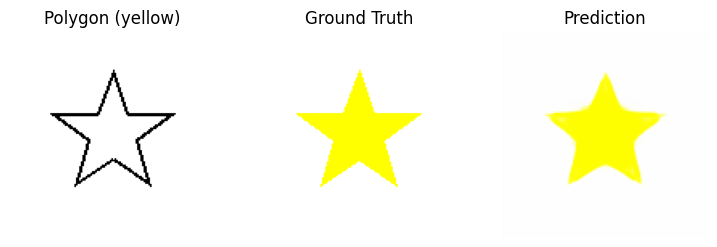

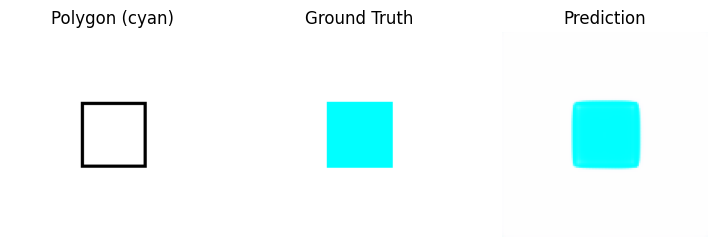

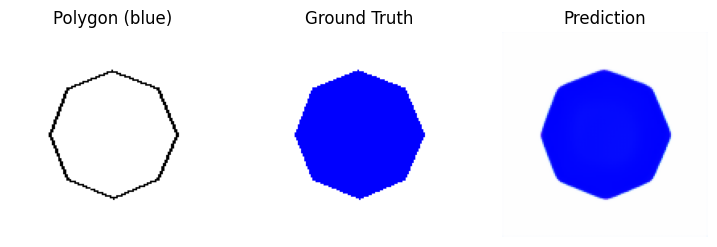

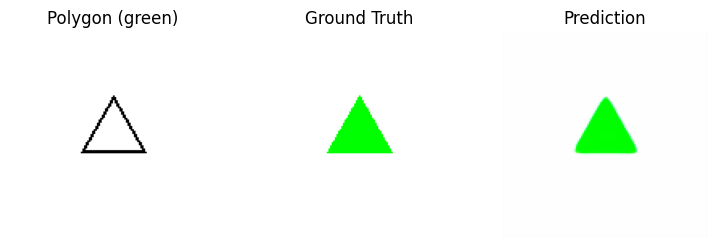

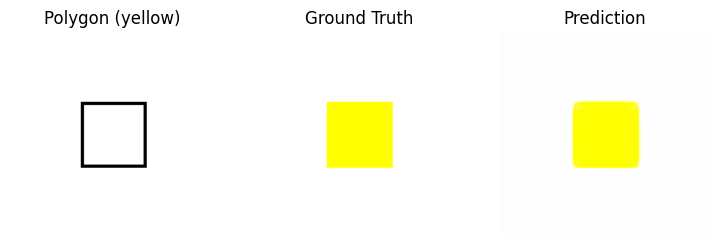

In [6]:
#Testing
import os
import json
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as TF

VAL_ROOT = "/kaggle/input/polygon-color/dataset/validation"
CHECKPOINT_PATH = "checkpoints/best_model.pt"   
N_SAMPLES = 5                                   

model, color2idx = load_model(CHECKPOINT_PATH)
model.eval()

def visualize_sample(polygon_path, color_name, gt_path=None):
    img = Image.open(polygon_path).convert("L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    inp = TF.to_tensor(img).unsqueeze(0).to(DEVICE) 

    color_idx = torch.tensor([color2idx[color_name.lower()]], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        pred = model(inp, color_idx)
    pred_img = TF.to_pil_image(pred.squeeze(0).cpu().clamp(0, 1))

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Polygon ({color_name})")
    plt.axis('off')

    if gt_path:
        gt_img = Image.open(gt_path).resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        plt.subplot(1, 3, 2)
        plt.imshow(gt_img)
        plt.title("Ground Truth")
        plt.axis('off')
    else:
        plt.subplot(1, 3, 2)
        plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

with open(os.path.join(VAL_ROOT, "data.json"), "r") as f:
    val_data = json.load(f)
if isinstance(val_data, dict):
    val_data = list(val_data.values())

samples = random.sample(val_data, min(N_SAMPLES, len(val_data)))
for s in samples:
    polygon_path = os.path.join(VAL_ROOT, "inputs", s["input_polygon"])
    color_name = s["colour"]
    gt_path = os.path.join(VAL_ROOT, "outputs", s["output_image"])
    visualize_sample(polygon_path, color_name, gt_path)
